In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from nmf_methods.nmf_son.utils import load_results
from PIL import Image

np.random.seed(42)
np.set_printoptions(precision=3)

In [2]:
def plot_separate_H(H, img_size, figsize, fontsize, normalize_row=False, split=False, filename=None):
    rank = H.shape[0]
    if normalize_row:
        H /= np.linalg.norm(H, axis=1, keepdims=True)
    H3d = H.reshape(-1, img_size[0], img_size[1], order='F')
    if split:
        half_rank = int(rank / 2)
        fig, axs = plt.subplots(2, half_rank, figsize=figsize)
        i, j, cnt = 0, 0, 0
        while cnt < rank:
            img = axs[i, j].imshow(H3d[cnt, :, :], cmap='gray', vmin=0, vmax=1)
            axs[i, j].set_title(f'$h^{{{cnt + 1}}}$', fontsize=fontsize)
            axs[i, j].axis('off')
            # axs[i, j].set_ylim([0, 1])
            divider = make_axes_locatable(axs[i, j])
            cax = divider.append_axes('right', size='5%', pad=0.1)
            fig.colorbar(img, cax=cax, orientation='vertical')

            j += 1
            if cnt + 1 == half_rank:
                i = 1
                j = 0
            cnt += 1
    else:
        fig, axs = plt.subplots(1, rank, figsize=figsize)
        cnt = 0
        while cnt < rank:
            img = axs[cnt].imshow(H3d[cnt, :, :], cmap='gray', vmin=0, vmax=1)
            axs[cnt].set_title(f'$h^{{{cnt + 1}}}$', fontsize=fontsize)
            axs[cnt].axis('off')
            # axs[cnt].set_ylim([0, 1])
            divider = make_axes_locatable(axs[cnt])
            cax = divider.append_axes('right', size='5%', pad=0.1)
            fig.colorbar(img, cax=cax, orientation='vertical')

            cnt += 1
    plt.tight_layout()
    if filename:
        plt.savefig(filename)
        plt.close()


def plot_combined_H(H, img_size, figsize, normalize_row=False, split=False, filename=None):
    if normalize_row:
        H /= np.linalg.norm(H, axis=1, keepdims=True)

    H3d = H.reshape(-1, img_size[0], img_size[1], order='F')

    if split:
        half_rank = H.shape[0] // 2
        large_mat = np.vstack([np.hstack(H3d[:half_rank]), np.hstack(H3d[half_rank:])])
    else:
        large_mat = np.hstack(H3d)

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(large_mat, cmap='gray')
    cax = ax.inset_axes([1.05, 0, 0.05, 1])
    plt.colorbar(im, cax=cax)

    plt.tight_layout()

    if filename:
        plt.savefig(filename)
        plt.close()


def plot_W_mats(W, figsize, fontsize, split=False, filename=None, scale_y=False, log_scale=False, plot_title=None):
    rank = W.shape[1]
    wmin, wmax = np.min(W), np.max(W)

    if split:
        half_rank = int(rank / 2)
        fig, axs = plt.subplots(2, half_rank, figsize=figsize)
        axs = axs.ravel()
    else:
        fig, axs = plt.subplots(1, rank, figsize=figsize)

    for cnt, ax in enumerate(axs):
        ax.plot(W[:, cnt], linewidth=3)
        if scale_y:
            ax.set_ylim([min(0, wmin), wmax])
        if log_scale:
            ax.set_yscale('log')
        ax.set_title(f'$w_{{{cnt + 1}}}$', fontsize=fontsize)
        ax.set_xlabel('Bands')
        ax.set_ylabel('Reflectance')

    plt.tight_layout()
    if plot_title:
        fig.suptitle(plot_title, fontsize=25)
    if filename:
        fig.savefig(filename)
        plt.close()


def merge_images(images_list, filename, delete_images=False):
    imgs = [Image.open(i) for i in images_list]
    min_img_width = min(i.width for i in imgs)

    total_height = 0
    for i, img in enumerate(imgs):
        if img.width > min_img_width:
            imgs[i] = img.resize((min_img_width, int(img.height / img.width * min_img_width)), Image.ANTIALIAS)
        total_height += imgs[i].height

    img_merge = Image.new(imgs[0].mode, (min_img_width, total_height))
    y = 0
    for img in imgs:
        img_merge.paste(img, (0, y))
        y += img.height

    img_merge.save(filename)

    if delete_images:
        for fp in images_list:
            os.remove(fp)

In [3]:
# jasper small
M = np.load('../../experimental/datasets/jasper_small.npz')['X']
m, n = M.shape

r = 20
_lam = 1000
max_iters = 10000


img_size = (50, 40)
w_plot_size = (32, 8)
h_plot_size = (32, 8)

In [4]:
save_filepath = '../../experimental/saved_models/jasper_small/r{}_l{}_mit{}.npz'
W, H, fscores, gscores, lvals = load_results(save_filepath.format(r, _lam, max_iters))

In [25]:
def similarity(W_ins):
    r = W_ins.shape[1]
    res = np.ones(shape=(r, r)) * -1
    for i in range(r):
        for j in range(r):
            res[i, j] = np.linalg.norm(W_ins[:, i] - W_ins[:, j])
        res[i, :] = res[i, :] / sum(res[i, :])
    return res

def columns_below_threshold(W_ins, threshold):
    n_cols = W_ins.shape[1]
    indices = []
    for i in range(n_cols):
        for j in range(n_cols):
            if i != j and np.linalg.norm(W_ins[:,i] - W_ins[:,j]) < threshold:
                print(i, j)
                indices.append((i, j))
    return sorted(list(set(indices)))

def plot_W_mats_2(W, figsize, fontsize, n_rows=1, filename=None, scale_y=False, plot_title=None):
    rank = W.shape[1]
    wmin, wmax = np.min(W), np.max(W)

    n_cols = int(np.ceil(rank / n_rows))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    axs = axs.ravel()

    for cnt, ax in enumerate(axs):
        if cnt < rank:
            ax.plot(W[:, cnt], linewidth=3)
            if scale_y:
                ax.set_ylim([min(0, wmin), wmax])

            ax.set_title(f'$w_{{{cnt + 1}}}$', fontsize=fontsize)
            ax.set_xlabel('Bands')
            ax.set_ylabel('Reflectance')
        else:
            ax.axis('off')

    plt.tight_layout()
    if plot_title:
        fig.suptitle(plot_title, fontsize=25)
    if filename:
        fig.savefig(filename)
        plt.close()

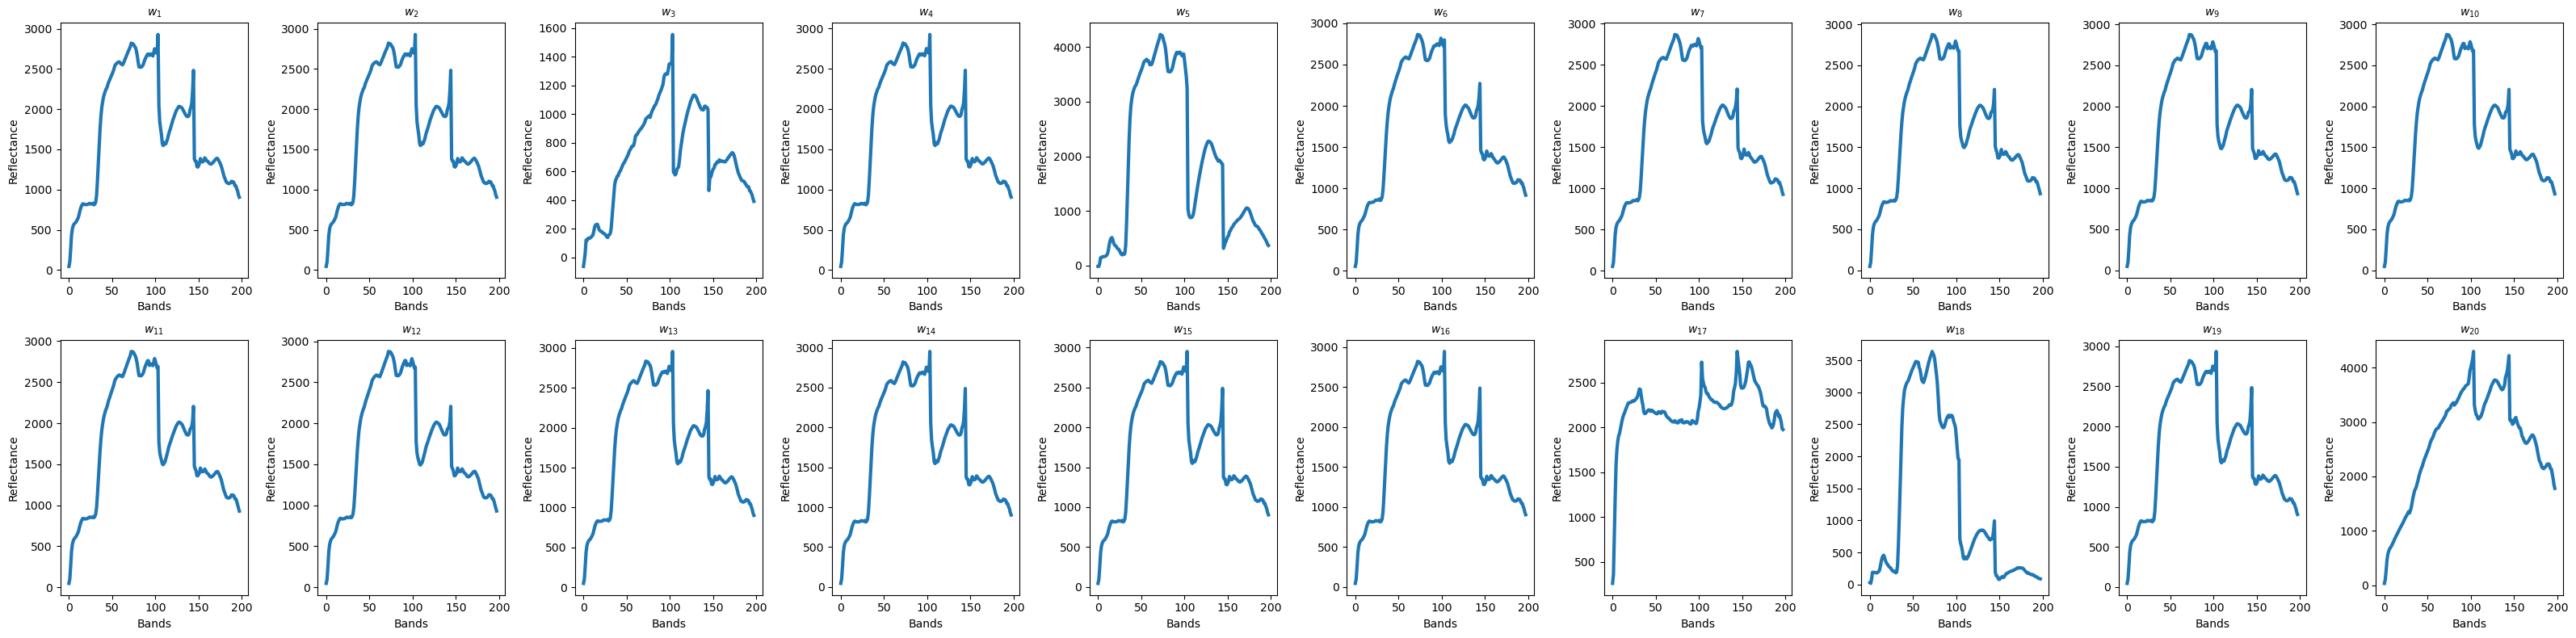

In [27]:
plot_W_mats_2(W, w_plot_size, fontsize=10, n_rows=2)

In [42]:
unique_idxs = [2, 4, 16, 17, 19]
other_idxs = [x for x in range(r) if x not in unique_idxs]

In [43]:
# sum
hsum = H[other_idxs, :].sum(axis=0, keepdims=True)
wsum = W[:, other_idxs].sum(axis=1, keepdims=True)

new_W = np.hstack((W[:, unique_idxs], wsum))
new_H = np.vstack((H[unique_idxs, :], hsum))

In [44]:
# mean
havg = H[other_idxs, :].mean(axis=0, keepdims=True)
wavg = W[:, other_idxs].mean(axis=1, keepdims=True)

new_W = np.hstack((W[:, unique_idxs], wavg))
new_H = np.vstack((H[unique_idxs, :], havg))

In [45]:
# max_idxs = np.argmax(new_H, axis=0)
# thres_H = np.zeros_like(new_H)
# thres_H[max_idxs, np.arange(new_H.shape[1])] = 1

In [46]:
for threshold in [0.2]:
    tmp_H = new_H.copy()
    tmp_H[tmp_H >= threshold] = 1
    tmp_H[tmp_H < threshold] = 0

    plot_W_mats(new_W, figsize=w_plot_size, fontsize=15, filename=f'../../experimental/images/jasper_small/w_vanilla_r{r}_mit{max_iters}.png')
    plot_separate_H(tmp_H, img_size, figsize=h_plot_size, fontsize=15, filename=f'../../experimental/images/jasper_small/seph_vanilla_r{r}_mit{max_iters}.png')
    plot_combined_H(tmp_H, img_size, figsize=h_plot_size, filename=f'../../experimental/images/jasper_small/combh_vanilla_r{r}_mit{max_iters}.png')
    merge_images([f'../../experimental/images/jasper_small/w_vanilla_r{r}_mit{max_iters}.png', f'../../experimental/images/jasper_small/seph_vanilla_r{r}_mit{max_iters}.png', f'../../experimental/images/jasper_small/combh_vanilla_r{r}_mit{max_iters}.png'], f'../../experimental/images/jasper_small/r{r}_sum_thes_{str(threshold).replace(".", "_")}.png', delete_images=True)

In [47]:
# plot_W_mats(new_W, figsize=w_plot_size, fontsize=15, filename=f'../../experimental/images/jasper_small/w_vanilla_r{r}_mit{max_iters}.png')
# plot_separate_H(thres_H, img_size, figsize=h_plot_size, fontsize=15, filename=f'../../experimental/images/jasper_small/seph_vanilla_r{r}_mit{max_iters}.png')
# plot_combined_H(thres_H, img_size, figsize=h_plot_size, filename=f'../../experimental/images/jasper_small/combh_vanilla_r{r}_mit{max_iters}.png')
# merge_images([f'../../experimental/images/jasper_small/w_vanilla_r{r}_mit{max_iters}.png', f'../../experimental/images/jasper_small/seph_vanilla_r{r}_mit{max_iters}.png', f'../../experimental/images/jasper_small/combh_vanilla_r{r}_mit{max_iters}.png'], f'../../experimental/images/jasper_small/ini_{ini_ver}/r{r}_sum_thes_max.png', delete_images=True)